In [524]:

# Data Processing
import numpy as np
import pandas as pd

# ML models
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.mixture import GaussianMixture
from sklearn.preprocessing import StandardScaler, LabelEncoder, MinMaxScaler

# Dimension Reduction
from sklearn.decomposition import PCA
from sklearn.manifold import MDS, TSNE, LocallyLinearEmbedding

# Statistics
from scipy.spatial import procrustes
from scipy.stats import pearsonr

# Visualization
import matplotlib.pyplot as plt

# Image processing
from PIL import Image, ImageOps
import os
import cv2

import warnings
warnings.filterwarnings("ignore")


Global Variables and file paths


In [525]:
RANDOM_STATE = 99
IMAGE_FOLDER = "Data/Rock_Images"
VALIDATION_FOLDER = "Data/Validation_Images"
HUMAN_PREDICTIVE_FEATURES = "Data/mds_360.txt"

### Pre Processing
Load the rock images

In [526]:
def load_images_from_folder(folder):

    images = []
    filenames = []
    labels = []

    for filename in os.listdir(folder):
        
        if filename[0] == 'I':
          labels.append('Igneous')
        elif filename[0] == "M":
          labels.append("Metamorphic")
        else:
          labels.append("Sedimentary")
  

        if filename.endswith(".jpg"):
            img = Image.open(os.path.join(folder, filename))
            img = ImageOps.grayscale(img)
            img = img.resize((256, 256))
            img_array = np.array(img)

            images.append(img_array.flatten())
            filenames.append(filename)

    return images, filenames, labels


image_data, image_filenames, LABELS = load_images_from_folder(IMAGE_FOLDER)

In [527]:
len(image_data)

360

In [528]:
len(image_data[0])

65536

The total number of features after converting to grayscale, resizing and flatenning image is 65536.

In [529]:
DATA = pd.DataFrame(columns = list(range(len(image_data[0]))))
for img in image_data:
  img = list(img)
  DATA.loc[len(DATA)] = img


### Queston 1
Apply PCA to the images from folder '360 Rocks'. How many components do you need to preserve 90% of the variance?


In [530]:
print(DATA.shape)

(360, 65536)


In [531]:
DATA.head()

,0,1,2,3,4,5,6,7,8,9,...,65526,65527,65528,65529,65530,65531,65532,65533,65534,65535
0,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255,255,...,255,255,255,255,255,255,255,255,255,255


In [532]:
pca = PCA(n_components = 0.9, svd_solver = "full")
X_reduced = pca.fit_transform(DATA)
X_recovered = pca.inverse_transform(X_reduced)

In [533]:
print("Length of reduced vector to preserve 90% variance: ", len(X_reduced[0]))

Length of reduced vector to preserve 90% variance:  141


Number of components required to preserve 90% variance: 141


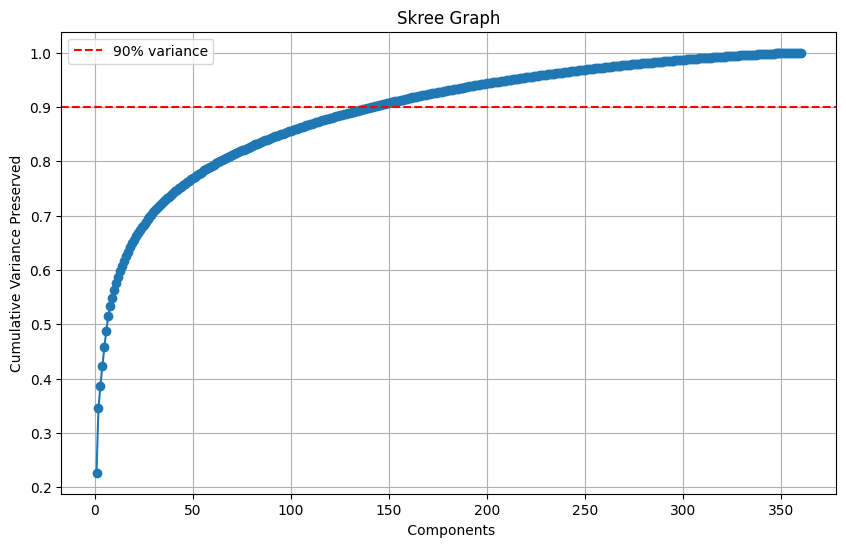

In [534]:
# Getting cumulative variance preserved for every feature included in the PCA.

pca = PCA(svd_solver = "full")

pca.fit(DATA)

cumulative_variance = pca.explained_variance_ratio_.cumsum()

n_components_90 = (cumulative_variance >= 0.90).argmax() + 1

print(f"Number of components required to preserve 90% variance: {n_components_90}")

plt.figure(figsize=(10, 6))
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel(' Components')
plt.ylabel('Cumulative Variance Preserved')
plt.title('Skree Graph')
plt.axhline(y=0.90, color='r', linestyle='--', label="90% variance")
plt.legend()
plt.grid(True)
plt.show()


### Question 2
Plot 10 images of your choice in the original form (without PCA) and then plot their reconstruction (projection in the original space) after you kept 90% of variance using PCA

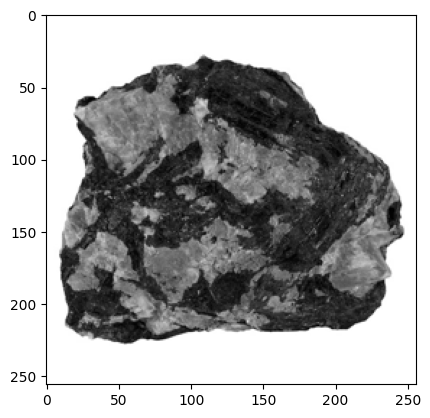

In [535]:
plt.imshow(np.array(DATA.iloc[0, : ]).reshape((256, 256)), cmap = 'grey')
plt.show()

In [536]:
pca = PCA(n_components = 0.9, svd_solver = "full")
X_reduced = pca.fit_transform(DATA)
X_recovered = pca.inverse_transform(X_reduced)

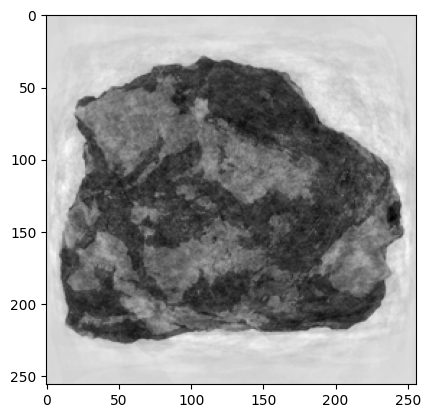

In [537]:
plt.imshow(X_recovered[0].reshape((256, 256)), cmap = "grey")
plt.show()

<Figure size 1000x1500 with 0 Axes>

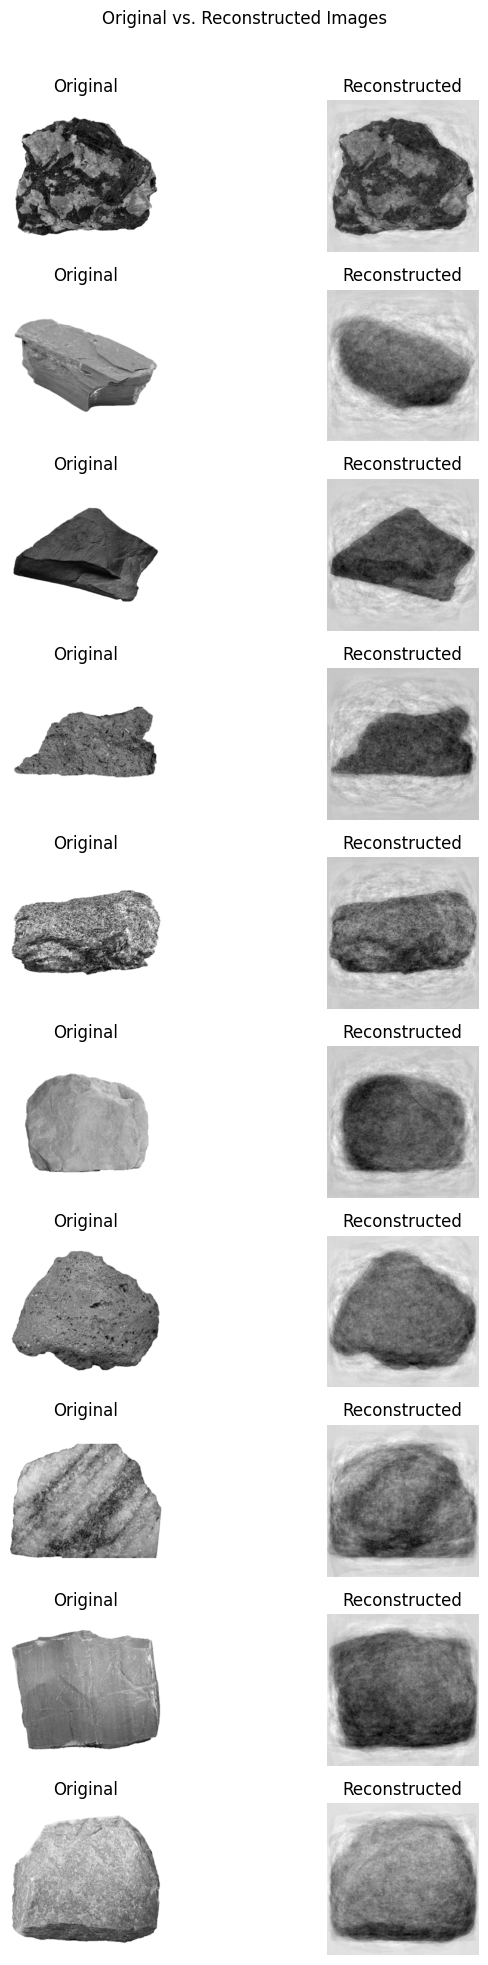

In [538]:
# Plotting the images pre and post reconstruction side by side:

num_images = 10
sample_indices = range(num_images)

plt.figure(figsize = (10, 15))

fig, axes = plt.subplots(num_images, 2, figsize=(8, num_images * 2))

for i, idx in enumerate(sample_indices):
    axes[i, 0].imshow(np.array(DATA.iloc[idx, : ]).reshape((256, 256)), cmap='gray')
    axes[i, 0].set_title("Original")
    axes[i, 0].axis('off')

    axes[i, 1].imshow(X_recovered[idx].reshape((256, 256)), cmap='gray')
    axes[i, 1].set_title("Reconstructed")
    axes[i, 1].axis('off')

plt.suptitle("Original vs. Reconstructed Images")
plt.tight_layout(rect=[0, 0, 1, 0.97])
plt.show()

### Question 3

Each of the images belongs to one of three rock categories. The category is indicated by the first letter in the filename (I, M and S). We will now try to see if the visualization can help us identify different clusters

#### 3.A
Use PCA to reduce dimensionality to only 2 dimensions. How much of the variance is explained with the first two principal components?

In [539]:
pca_two = PCA(n_components = 2)
X_reduced_two = pca_two.fit_transform(DATA)
X_recovered_two = pca_two.inverse_transform(X_reduced_two)

In [540]:
pca_two.explained_variance_ratio_

array([0.22656558, 0.11828768])

In [541]:
print("Total variance explained by the first two components: ", sum(pca_two.explained_variance_ratio_))

Total variance explained by the first two components:  0.34485326719873166


In [542]:
plot_data = pd.DataFrame(columns = ["PC1", "PC2", "Label"])

for itr in range(len(X_reduced_two)):
  curr_row = [X_reduced_two[itr][0], X_reduced_two[itr][1], LABELS[itr]]
  plot_data.loc[len(plot_data)] = curr_row

In [543]:
plot_data

,PC1,PC2,Label
0,-10060.540713,604.926789,Igneous
1,8948.132587,982.455638,Metamorphic
2,3528.565031,7298.921584,Sedimentary
3,8749.939384,3357.946508,Igneous
4,4897.865937,4207.866535,Metamorphic
...,...,...,...
355,8070.921417,468.118527,Sedimentary
356,-5421.477062,-344.126643,Metamorphic
357,9097.087505,2232.396305,Metamorphic
358,9272.655568,-7705.181333,Metamorphic


#### 3.B

Plot a 2D scatter plot of the images spanned by the first two principal components. Each image will be represented with a dot. Make the color of the dot correspond to the image category (so you will have three different colors). Then add some rock images to the visualization to better understand what features in the images are accounting for the majority of variance in the data (your visualization should look similar to the one after line 71 in this file https://github.com/ageron/handson-ml3/blob/main/08_dimensionality_reduction.ipynbLinks to an external site. but with images of rocks instead of MNIST digits). Repeat the process and create the same type of plots for t-SNE, LLE and MDS. [6 points]

In [544]:
from sklearn.preprocessing import MinMaxScaler
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

def plot_digits(X, y, min_distance=0.04, images=None, figsize=(13, 10)):
    # Let's scale the input features so that they range from 0 to 1
    X_normalized = MinMaxScaler().fit_transform(X)
    # Now we create the list of coordinates of the digits plotted so far.
    # We pretend that one is already plotted far away at the start, to
    # avoid `if` statements in the loop below
    neighbors = np.array([[10., 10.]])
    # The rest should be self-explanatory
    plt.figure(figsize=figsize)
    cmap = plt.cm.jet
    digits = np.unique(y)
    for digit in digits:
        plt.scatter(X_normalized[y == digit, 0], X_normalized[y == digit, 1],
                    c=[cmap(float(digit) / 9)], alpha=0.5)
    plt.axis("off")
    ax = plt.gca()  # get current axes
    for index, image_coord in enumerate(X_normalized):
        closest_distance = np.linalg.norm(neighbors - image_coord, axis=1).min()
        if closest_distance > min_distance:
            neighbors = np.r_[neighbors, [image_coord]]
            if images is None:
                plt.text(image_coord[0], image_coord[1], str(int(y[index])),
                         color=cmap(float(y[index]) / 9),
                         fontdict={"weight": "bold", "size": 16})
            else:
                image = np.array(images.iloc[index, : ]).reshape((256, 256))
                image = cv2.resize(image, (28, 28))
                imagebox = AnnotationBbox(OffsetImage(image),
                                          image_coord, frameon=False, arrowprops=dict(arrowstyle="->"))
                ax.add_artist(imagebox)

Total variance explained by the first two components:  0.3448532671987316


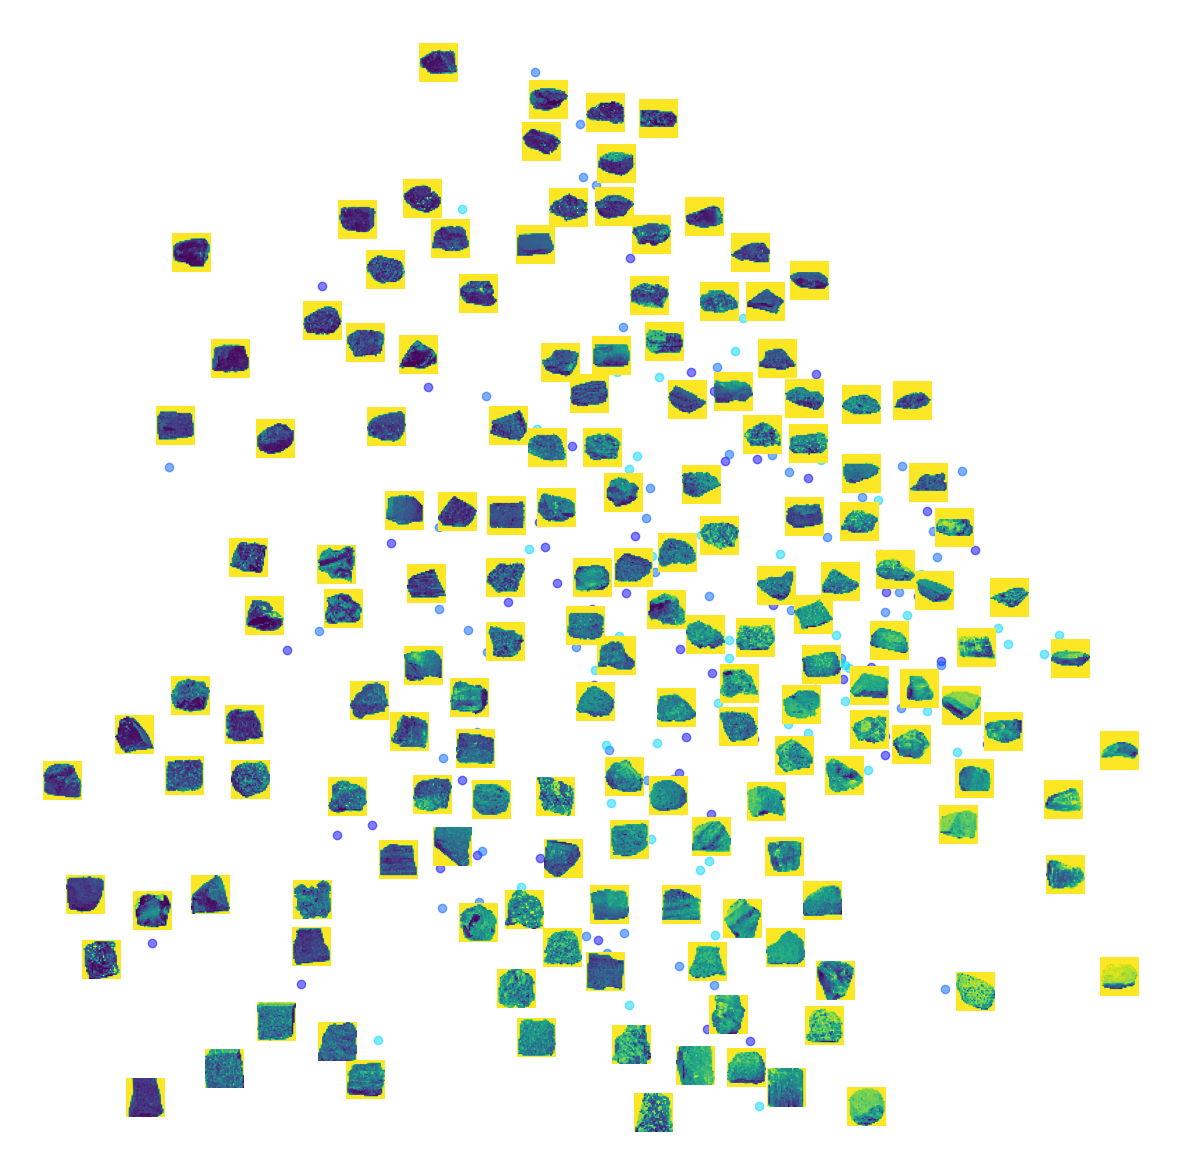

In [545]:
pca_two = PCA(n_components = 2)
X_reduced_two = pca_two.fit_transform(DATA)
X_recovered_two = pca_two.inverse_transform(X_reduced_two)

print("Total variance explained by the first two components: ", sum(pca_two.explained_variance_ratio_))

plot_data = pd.DataFrame(columns = ["PC1", "PC2", "Label"])

for itr in range(len(X_reduced_two)):
  curr_row = [X_reduced_two[itr][0], X_reduced_two[itr][1], LABELS[itr]]
  plot_data.loc[len(plot_data)] = curr_row

rock_mapping = {
    "Igneous" : 1,
    "Metamorphic" : 2,
    "Sedimentary" : 3
}

num_labels = plot_data['Label'].apply(lambda x : rock_mapping[x])
plot_digits(plot_data[["PC1", "PC2"]], num_labels, images = DATA, figsize=(15, 15))

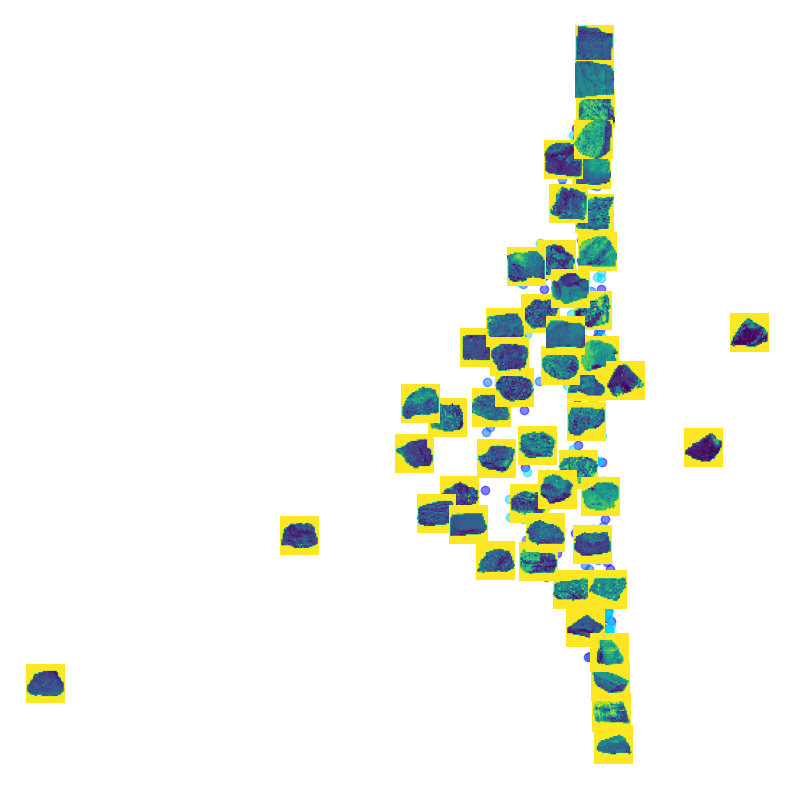

In [546]:
from sklearn.manifold import LocallyLinearEmbedding
import pandas as pd

# Step 1: Perform LLE with 2 components
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10)  # Adjust n_neighbors as needed
X_reduced_lle = lle.fit_transform(DATA)

# Step 2: Create DataFrame for LLE results
plot_data_lle = pd.DataFrame(columns=["PC1", "PC2", "Label"])

for itr in range(len(X_reduced_lle)):
    curr_row = [X_reduced_lle[itr][0], X_reduced_lle[itr][1], LABELS[itr]]
    plot_data_lle.loc[len(plot_data_lle)] = curr_row

# Map rock types to numerical values
rock_mapping = {
    "Igneous": 1,
    "Metamorphic": 2,
    "Sedimentary": 3
}

num_labels_lle = plot_data_lle['Label'].apply(lambda x: rock_mapping[x])

# Assuming plot_digits is a function to plot the data
# Replace plot_digits with appropriate plotting function if necessary
plot_digits(plot_data_lle[["PC1", "PC2"]], num_labels_lle, images=DATA, figsize=(10, 10))

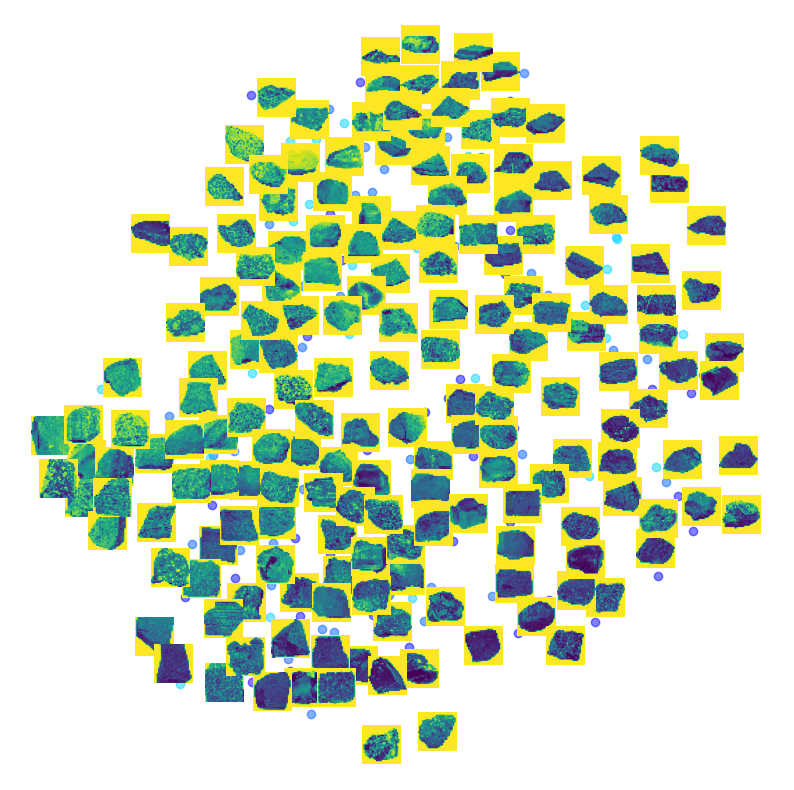

In [547]:
from sklearn.manifold import TSNE
import pandas as pd

# Step 1: Perform t-SNE with 2 components
tsne = TSNE(n_components=2, perplexity=30, random_state=0)  # Adjust perplexity as needed
X_reduced_tsne = tsne.fit_transform(DATA)

# Step 2: Create DataFrame for t-SNE results
plot_data_tsne = pd.DataFrame(columns=["PC1", "PC2", "Label"])

for itr in range(len(X_reduced_tsne)):
    curr_row = [X_reduced_tsne[itr][0], X_reduced_tsne[itr][1], LABELS[itr]]
    plot_data_tsne.loc[len(plot_data_tsne)] = curr_row

# Map rock types to numerical values
rock_mapping = {
    "Igneous": 1,
    "Metamorphic": 2,
    "Sedimentary": 3
}

num_labels_tsne = plot_data_tsne['Label'].apply(lambda x: rock_mapping[x])

# Assuming plot_digits is a function to plot the data
# Replace plot_digits with appropriate plotting function if necessary
plot_digits(plot_data_tsne[["PC1", "PC2"]], num_labels_tsne, images=DATA, figsize=(10, 10))


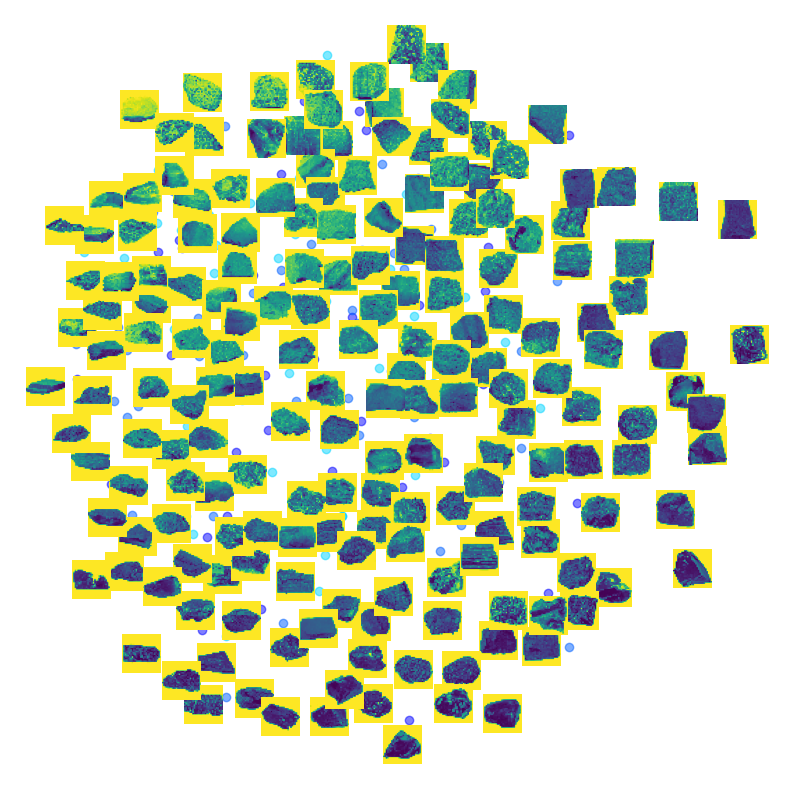

In [548]:

# Step 1: Perform MDS with 2 components
mds = MDS(n_components=2, random_state=0)  # You can adjust parameters as needed
X_reduced_mds = mds.fit_transform(DATA)

# Step 2: Create DataFrame for MDS results
plot_data_mds = pd.DataFrame(columns=["MDS1", "MDS2", "Label"])

for itr in range(len(X_reduced_mds)):
    curr_row = [X_reduced_mds[itr][0], X_reduced_mds[itr][1], LABELS[itr]]
    plot_data_mds.loc[len(plot_data_mds)] = curr_row

# Map rock types to numerical values
rock_mapping = {
    "Igneous": 1,
    "Metamorphic": 2,
    "Sedimentary": 3
}

num_labels_mds = plot_data_mds['Label'].apply(lambda x: rock_mapping[x])

# Assuming plot_digits is a function to plot the data
# Replace plot_digits with appropriate plotting function if necessary
plot_digits(plot_data_mds[["MDS1", "MDS2"]], num_labels_mds, images=DATA, figsize=(10, 10))


### Question 4 

Now let's see if these dimensionality reduction techniques can give us similar features to those that humans use to judge the images. File mds_360.txt contains 8 features for each of the images (rankings are in the same order as the images in  '360 Rocks' folder. Run PCA, LLE and MDS to reduce the dimensionality of the images to 8.

In [549]:
matrix_with_human_data = np.loadtxt(HUMAN_PREDICTIVE_FEATURES)
print(matrix_with_human_data)
print("Shape of Most important features for humans", matrix_with_human_data.shape)


procrustes_analysis = []

[[-3.743 -1.204  2.001 ... -1.992  4.95   1.695]
 [ 2.332  1.625  0.985 ...  0.093  6.724  0.708]
 [ 0.346  1.49  -3.795 ... -3.786  0.706 -2.854]
 ...
 [-3.475 -3.431 -2.184 ... -2.265  1.129 -1.201]
 [-0.051 -2.358  1.994 ...  7.268 -0.593 -1.432]
 [ 1.134 -4.9    0.983 ...  4.695  0.624 -1.195]]
Shape of Most important features for humans (360, 8)


#### PCA

In [550]:
mds = PCA(n_components=8, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = mds.fit_transform(DATA)
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_pca_embeddings_data)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())

pca_result = {
        'Embedding': 'PCA',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(pca_result)

print('Embedding: PCA')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: PCA
Disparity: 0.9882898436851537
Correlation: 0.1082134756619817
P_value: 5.817315253326653e-09


#### LLE

In [551]:
lle = LocallyLinearEmbedding(n_components=8, n_neighbors=10) 
matrix_with_lle_embeddings_data = lle.fit_transform(DATA)
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_lle_embeddings_data)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())
lle_result = {
        'Embedding': 'LLE',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(lle_result)

print('Embedding: LLE')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: LLE
Disparity: 0.9868452297123393
Correlation: 0.11469424696845434
P_value: 6.707120377799131e-10


#### MDS

In [552]:
mds = MDS(n_components=8, random_state=RANDOM_STATE)
matrix_with_mds_embeddings_data = mds.fit_transform(DATA)
mtx1, mtx2, disparity = procrustes(matrix_with_human_data, matrix_with_mds_embeddings_data)
stat, p_value = pearsonr(mtx1.ravel(), mtx2.ravel())

mds_result = {
        'Embedding': 'MDS',
        'Disparity': disparity,
        'Correlation': stat,
        'P_Value': p_value
}

procrustes_analysis.append(mds_result)

print('Embedding: MDS')
print(f'Disparity: {disparity}')
print(f'Correlation: {stat}')
print(f'P_value: {p_value}')

Embedding: MDS
Disparity: 0.9879922010282548
Correlation: 0.10958010299203658
P_value: 3.7265676786305395e-09


In [553]:
human_comparison_df = pd.DataFrame(procrustes_analysis).sort_values(by='Disparity')
display(human_comparison_df)

,Embedding,Disparity,Correlation,P_Value
1,LLE,0.986845,0.114694,6.707120e-10
2,MDS,0.987992,0.109580,3.726568e-09
0,PCA,0.988290,0.108213,5.817315e-09


### Question 5

Cluster the 360 images using K-Means

In [554]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
kmeans = KMeans(n_clusters=3, random_state=RANDOM_STATE, n_init="auto")
kmeans.fit_predict(matrix_with_pca_embeddings_data)
silhouette_avg = silhouette_score(DATA, kmeans.labels_)
print(silhouette_avg)


0.1079766243997143


In [555]:

encoded_labels = LabelEncoder().fit_transform(LABELS)
stat, p_value = pearsonr(encoded_labels, kmeans.labels_)
print(stat)

-0.09444523763865151


In [556]:
silhouette_scores = []
cluster_range = range(2, 25)
for n_clusters in cluster_range:
    kmeans = KMeans(n_clusters=n_clusters, random_state=RANDOM_STATE, n_init="auto")
    cluster_labels = kmeans.fit_predict(matrix_with_pca_embeddings_data)
    score = silhouette_score(matrix_with_pca_embeddings_data, cluster_labels)
    silhouette_scores.append(score)

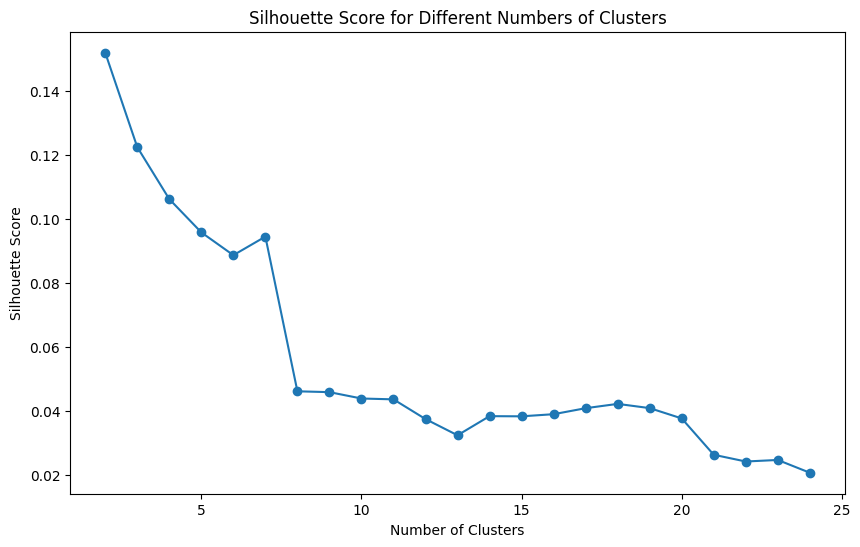

In [557]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.title("Silhouette Score for Different Numbers of Clusters")
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Score")
plt.show()

### Question 6

Cluster the 360 images using EM

In [558]:
pca = PCA(n_components=.90, random_state=RANDOM_STATE)
matrix_with_pca_embeddings_data = pca.fit_transform(DATA)
gm = GaussianMixture(n_components=3, random_state=RANDOM_STATE)

predicted = gm.fit_predict(matrix_with_pca_embeddings_data)

In [559]:
encoded_labels = LabelEncoder().fit_transform(LABELS)
stat, p_value = pearsonr(encoded_labels, predicted)
print(stat, p_value)

-0.09444523763865151 0.07349527712288709


In [560]:
bic_scores = []
aic_scores = []

for n_components in cluster_range:
    gm = GaussianMixture(n_components=n_components, random_state=RANDOM_STATE)
    gm.fit(matrix_with_pca_embeddings_data)
    bic_scores.append(gm.bic(matrix_with_pca_embeddings_data))
    aic_scores.append(gm.aic(matrix_with_pca_embeddings_data))

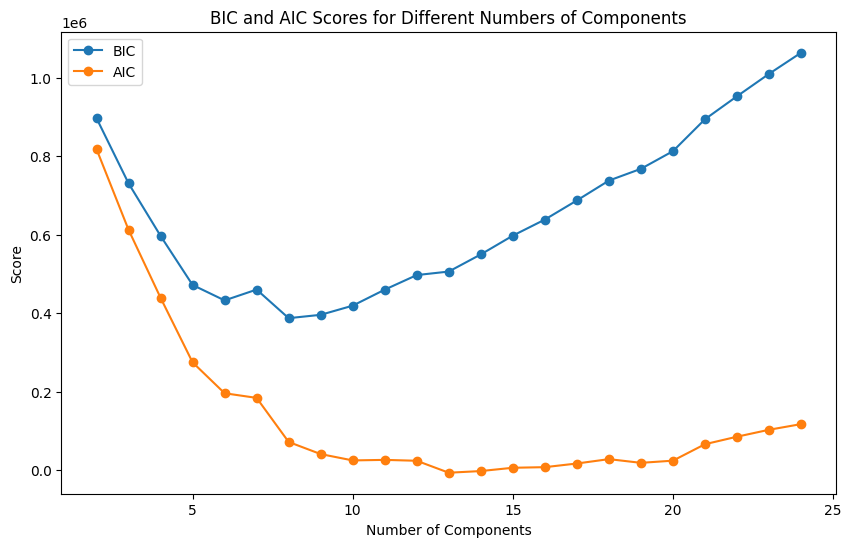

In [561]:
plt.figure(figsize=(10, 6))
plt.plot(cluster_range, bic_scores, label='BIC', marker='o')
plt.plot(cluster_range, aic_scores, label='AIC', marker='o')
plt.title("BIC and AIC Scores for Different Numbers of Components")
plt.xlabel("Number of Components")
plt.ylabel("Score")
plt.legend()
plt.show()

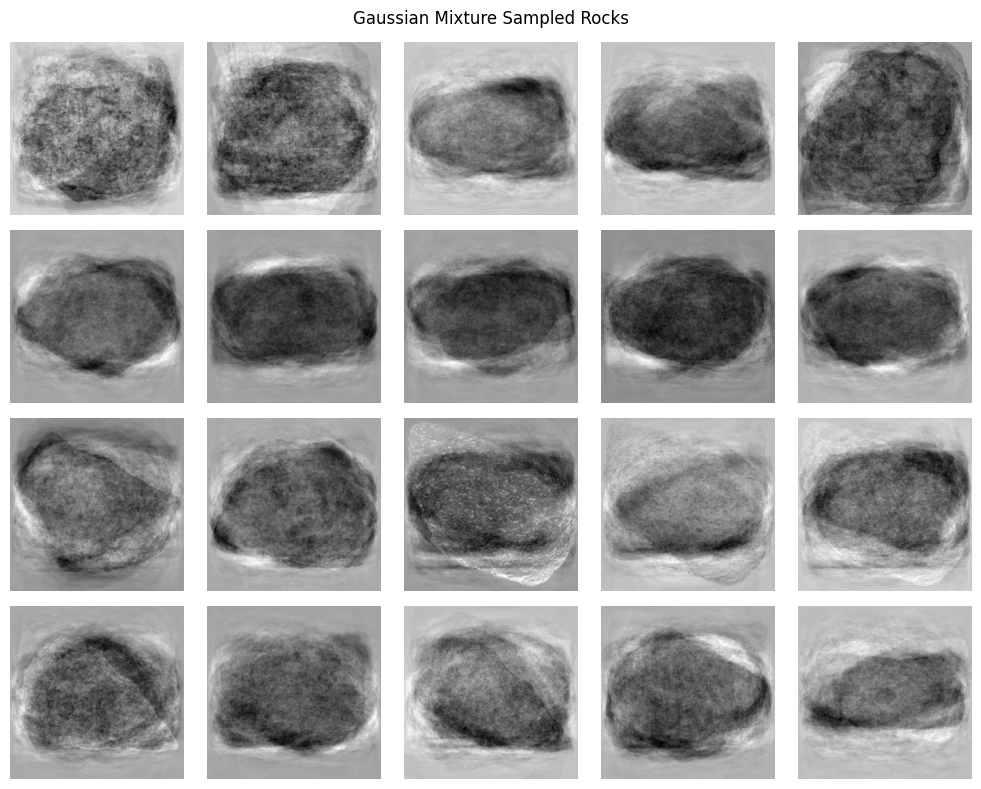

In [562]:
samples, _ = gm.sample(n_samples=20)
original_space_samples = pca.inverse_transform(samples)

fig, axes = plt.subplots(4, 5, figsize=(10, 8))
for i, ax in enumerate(axes.ravel()):
    ax.imshow(np.array(original_space_samples[i, : ]).reshape((256, 256)), cmap = 'grey')
    ax.axis('off')
plt.suptitle("Gaussian Mixture Sampled Rocks")
plt.tight_layout()
plt.show()

### Question 7 
Build a feedforward neural network (using dense and/or CNN layers) with a few hidden layers (we suggest using Keras (within Tensorflow) or Pytorch). Train the network to classify on 360 rock images using rock name as the label - the category is indicated by the first letter in the filename (I, M and S). Use images from '120 Rocks' folder as your validation data. Choose the number of neurons you find appropriate and efficient (so you have enough time to run it), but make the last layer before the softmax should consist of 8 neurons. The hidden layers should have ReLU activation function. Train the network for multiple epochs until it converges (if the process is too slow, tweak the learning rate and consider simplifying your network). We will not deduct points based on the simplicity of your network, but we expect you to have performance that is above chance performance that could be obtained with an untrained network - in other words, we expect to see train and validation loss decrease and accuracy increase throughout the training

In [563]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, TensorDataset


In [580]:

image_data, image_filenames, VALIDATION_LABELS = load_images_from_folder(VALIDATION_FOLDER)

VALIDATION_DATA = pd.DataFrame(columns = list(range(len(image_data[0]))))
for img in image_data:
  img = list(img)
  VALIDATION_DATA.loc[len(VALIDATION_DATA)] = img

#### Converting Data

In [581]:
features = DATA.values
val_features = VALIDATION_DATA.values

le = LabelEncoder()
encoded_labels = le.fit_transform(LABELS)
val_encoded_labels = le.fit_transform(VALIDATION_LABELS)


print(len(features))
print(len(encoded_labels))

print(len(val_features))
print(len(val_encoded_labels))

360
360
120
120


In [582]:

features_tensor = torch.tensor(features, dtype=torch.float32) 
labels_tensor = torch.tensor(encoded_labels, dtype=torch.long) 

train_dataset = TensorDataset(features_tensor, labels_tensor)
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True)


In [583]:
val_features_tensor = torch.tensor(val_features, dtype=torch.float32) 
val_labels_tensor = torch.tensor(val_encoded_labels, dtype=torch.long) 

val_dataset = TensorDataset(val_features_tensor, val_labels_tensor)
val_dataloader = DataLoader(val_dataset, batch_size=32, shuffle=True)

In [591]:
print(len(val_dataset[0][0]))

65536


#### Building The Model

In [ ]:
class RockClassifier(nn.Module):
    def __init__(self):
        super(RockClassifier, self).__init__()
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(256 * 256, 1) 
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(512, 1)
        self.softmax = nn.Softmax(dim=1) 

    def forward(self, x):
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.relu(x)
        return self.softmax(x)

In [585]:
model = RockClassifier()
criterion = nn.CrossEntropyLoss()  
optimizer = optim.Adam(model.parameters(), lr=0.001)  


#### 7.A
Report Training Time

#### 7.B 
Plot training and validation lost as a function of training epochs

In [586]:
num_epochs = 20
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Lists to store metrics for each epoch
training_accuracy = []
validation_accuracy = []
training_loss = []
validation_loss = []

for epoch in range(num_epochs):
    # Training
    model.train()
    train_correct, train_total, train_loss = 0, 0, 0
    
    for images, labels in train_dataloader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        train_correct += (outputs.argmax(1) == labels).sum().item()
        train_total += labels.size(0)

    train_accuracy = train_correct / train_total
    training_accuracy.append(train_accuracy)
    training_loss.append(train_loss / len(train_dataloader))

    # Validation
    model.eval()
    val_correct, val_total, val_loss = 0, 0, 0
    
    with torch.no_grad():
        for images, labels in val_dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            val_loss += criterion(outputs, labels).item()
            val_correct += (outputs.argmax(1) == labels).sum().item()
            val_total += labels.size(0)

    val_accuracy = val_correct / val_total
    validation_accuracy.append(val_accuracy)
    validation_loss.append(val_loss / len(val_dataloader))

    # Log results for the current epoch
    print(f"Epoch {epoch+1}/{num_epochs}, "
          f"Train Loss: {training_loss[-1]:.4f}, Train Accuracy: {training_accuracy[-1]:.4f}, "
          f"Val Loss: {validation_loss[-1]:.4f}, Val Accuracy: {validation_accuracy[-1]:.4f}")



RuntimeError: mat1 and mat2 shapes cannot be multiplied (32x65536 and 49152x512)

#### 7.C 

How many parameters does the network have? How many of those parameters are bias parameters?

#### 7.D

compare the activity of neurons in the next to the last layer (the one with 8 neurons) with the human data. (to get human data use mds_360.txt and mds_120.txt files). Similar to before, use Procrustes analysis to do the comparison.  For training and validation data (separately), report disparity and compute the correlation coefficient between each dimension of mtx1 and mtx2. Display results in a table. [3 points]